<a href="https://colab.research.google.com/github/Tahedi1/Workshop-plant-diseases-classifcation/blob/main/Workshop_deep_learning_for_plant_disease_classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the required packges

In [ ]:
import tensorflow as tf
print(tf.__version__)
 
from tensorflow.keras.applications import VGG16
 
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img,img_to_array,array_to_img
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sn
import random
import matplotlib.cm as cm

2.6.0


## Exploring data

Data exploration is very important to get idea about :

*   Dataset classes
*   Number of images in each class
*   Nature of images
*   ...



In [ ]:
!gdown "https://drive.google.com/u/0/uc?export=download&confirm=Eptv&id=0B_voCy5O5sXMTFByemhpZllYREU" 
!tar -xf /content/PlantVillage.tar.gz

Downloading...
From: https://drive.google.com/u/0/uc?export=download&confirm=Eptv&id=0B_voCy5O5sXMTFByemhpZllYREU
To: /content/PlantVillage.tar.gz
830MB [00:12, 67.6MB/s]


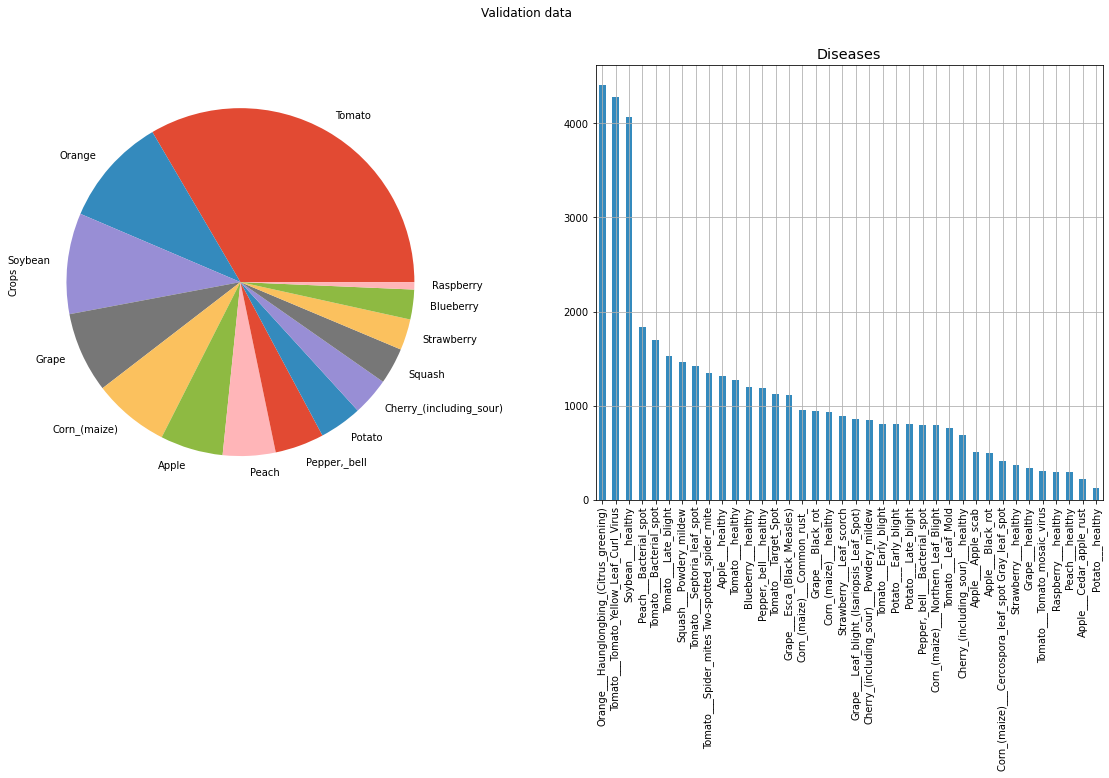

In [ ]:
train_path = '/content/PlantVillage/train'
lists = os.listdir(train_path)
diseases = []
crops = []
file_lst = []
for folder in lists:
    files = os.listdir(os.path.join(train_path,folder))
    files = [folder+'/'+file  for file in files]
    file_lst.extend(files)
    if(folder != 'background'): 
      diseases.extend([folder for i in range(len(files))])
      crops.extend([folder.split(sep='___')[0] for i in range(len(files))])
train_df = pd.DataFrame(list(zip(file_lst,crops,diseases)),columns =["Paths","Crops","Diseases"])

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(20,8))
with plt.style.context('ggplot'):
  train_df['Crops'].value_counts().plot(kind='pie', title='Validation data',ax = axes[0],subplots=True)
  train_df['Diseases'].value_counts().plot(kind='bar', color='C1',title='Validation data',ax = axes[1],subplots=True)

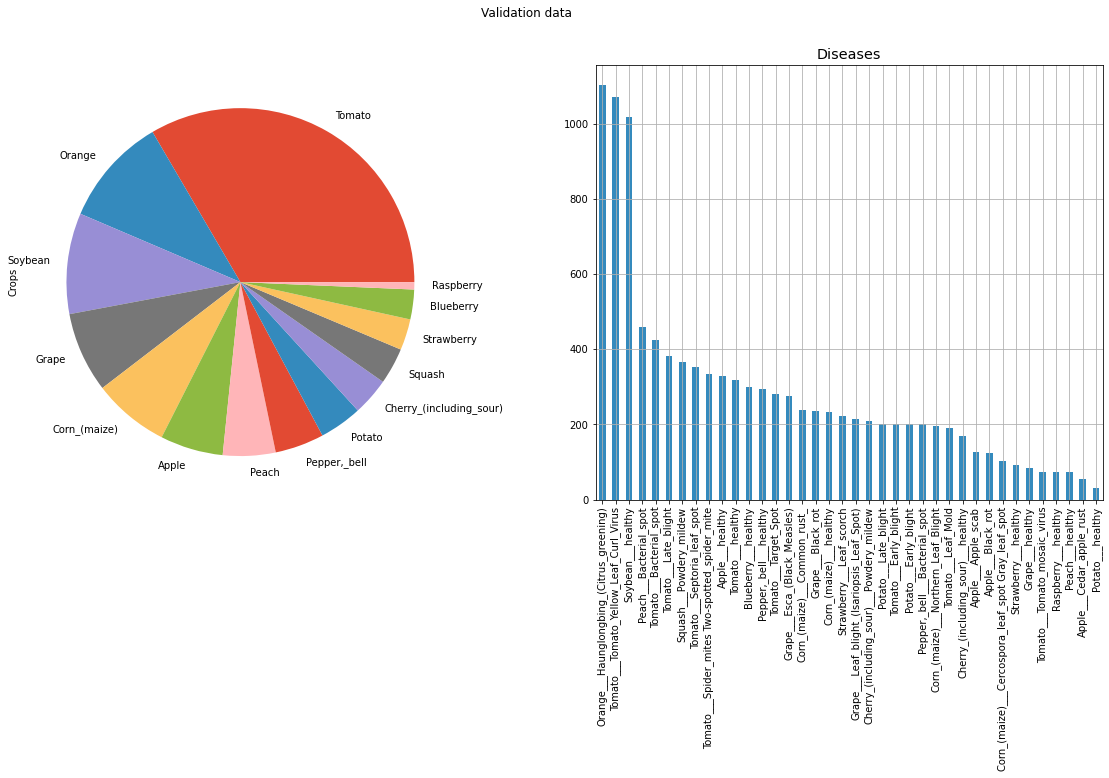

In [ ]:
validation_path = '/content/PlantVillage/val'
lists = os.listdir(validation_path)
diseases = []
crops = []
file_lst = []
for folder in lists:
    files = os.listdir(os.path.join(validation_path,folder))
    files = [folder+'/'+file  for file in files]
    file_lst.extend(files)
    if(folder != 'background'): 
      diseases.extend([folder for i in range(len(files))])
      crops.extend([folder.split(sep='___')[0] for i in range(len(files))])
validation_df = pd.DataFrame(list(zip(file_lst,crops,diseases)),columns =["Paths","Crops","Diseases"])

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(20,8))
with plt.style.context('ggplot'):
  validation_df['Crops'].value_counts().plot(kind='pie', title='Validation data',ax = axes[0],subplots=True)
  validation_df['Diseases'].value_counts().plot(kind='bar', color='C1',title='Validation data',ax = axes[1],subplots=True)

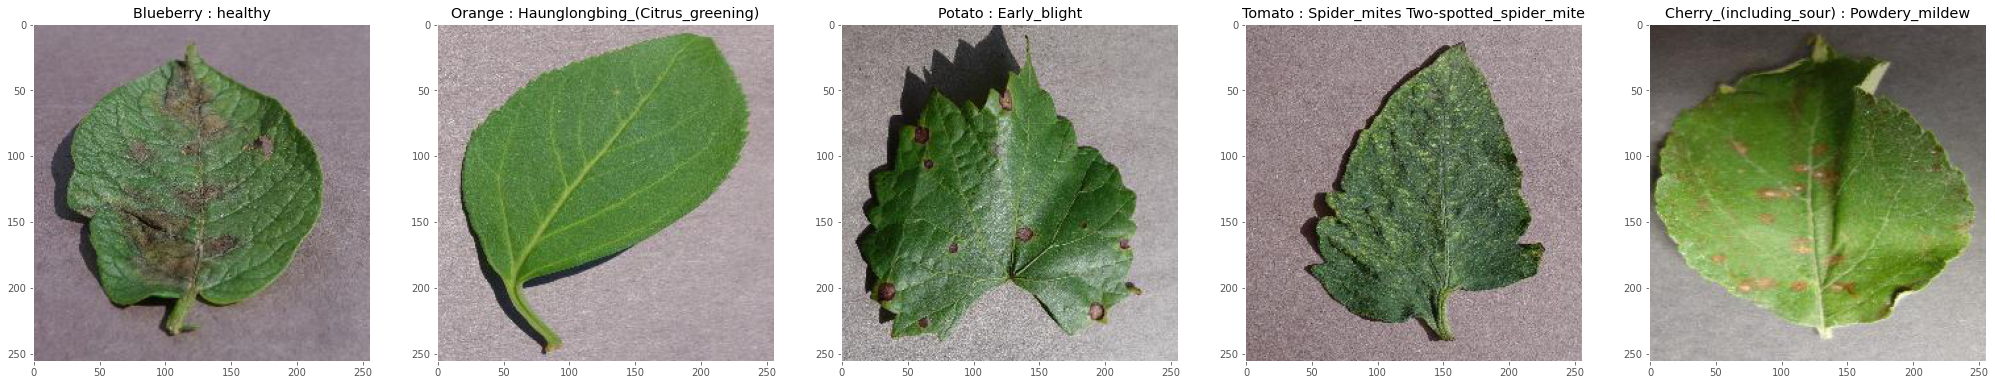

In [ ]:
number_images =5

selected_images_df = train_df.sample(number_images)

plt.rcParams["axes.grid"] = False
figure, ax = plt.subplots(1, number_images, figsize=(number_images*7,10)) 
plt.style.use('ggplot')
idx=0
for index, row in selected_images_df.iterrows():
  image = Image.open(os.path.join(train_path,row.Paths))

  disease = row.Diseases.split('___')[1]
  ax[idx].set_title(row.Crops + " : " + disease)
  ax[idx].imshow(image)
  idx= idx + 1

## Loading the Data for training


The keras function [**`ImageDataGenerator.flow_from_directory()`**](https://keras.io/api/preprocessing/image/) will be the interface between the dataset in disk and the training loop. 
it allows: 
*   Get images from disc in batches **Batch1**, **Batch2**, ...,**BatchN** 
*   Applies pre-processing operations on images
*  [Data augmentation]



In [ ]:
batch_size = 32
image_size = (224,224)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                  train_path,
                  target_size=image_size,
                  batch_size=batch_size
                  )

Found 44016 images belonging to 39 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = train_datagen.flow_from_directory(
                  validation_path,
                  target_size=image_size,
                  batch_size=batch_size,
                  shuffle=False,
                  )

Found 11004 images belonging to 39 classes.


# Model construction

In [ ]:
class_number = train_generator.num_classes

## Downloading the Pretrained Model

The [ImageNet pre-trained models](https://keras.io/api/applications/vgg/#vgg16-function) are often good choices for computer vision transfer learning, as they have learned to classify various different types of images. In doing this, they have learned to detect many different types of [features](https://developers.google.com/machine-learning/glossary#) that could be valuable in image recognition. 

Let us start by downloading the pre-trained model. Again, this is available directly from the Keras library. As we are downloading, there is going to be an important difference. The last layer of an ImageNet model is a [dense layer](https://developers.google.com/machine-learning/glossary#dense-layer) of 1000 units, representing the 1000 possible classes in the dataset. In our case, we want it to make a different classification: 38 plant diseases? Because we want the classification to be different, we are going to remove the last layer of the model. We can do this by setting the flag `include_top=False` when downloading the model. After removing this top layer, we can add new layers that will yield the type of classification that we want:

In [ ]:
base_model = VGG16(include_top =False,input_shape = (224,224,3))

58900480/58889256 [==============================] - 0s 0us/step


## Adding New Layers


We can now add the new trainable layers to the pre-trained model. They will take the features from the pre-trained layers and turn them into predictions on the new dataset. We will add two layers to the model. First will be a pooling layer like we saw in our earlier [convolutional neural network](https://developers.google.com/machine-learning/glossary#convolutional_layer). (If you want a more thorough understanding of the role of pooling layers in CNNs, please read [this detailed blog post](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/#:~:text=A%20pooling%20layer%20is%20a,Convolutional%20Layer). We then need to add our final layer, which will classify plant diseases. This will be a densely connected layer with one output.

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(class_number, activation='softmax')(x)
model = Model(base_model.input, predictions)

## Model graph visualization

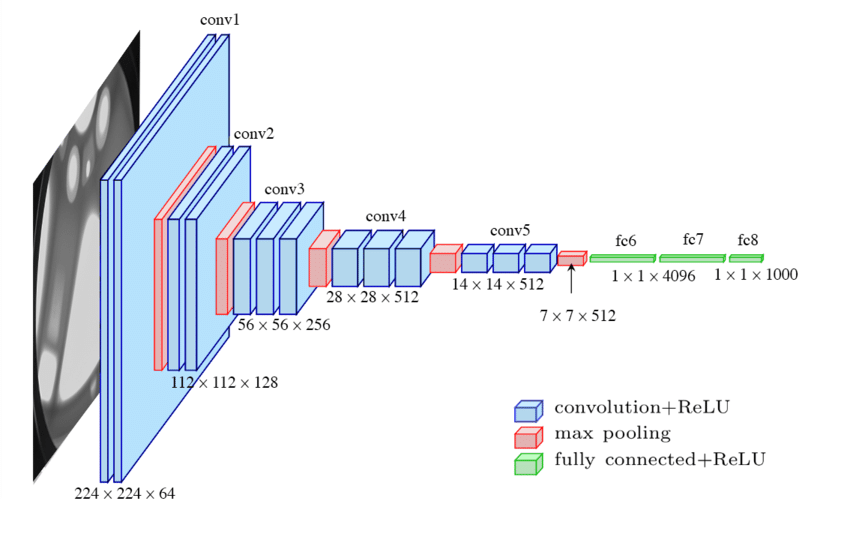

In [ ]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

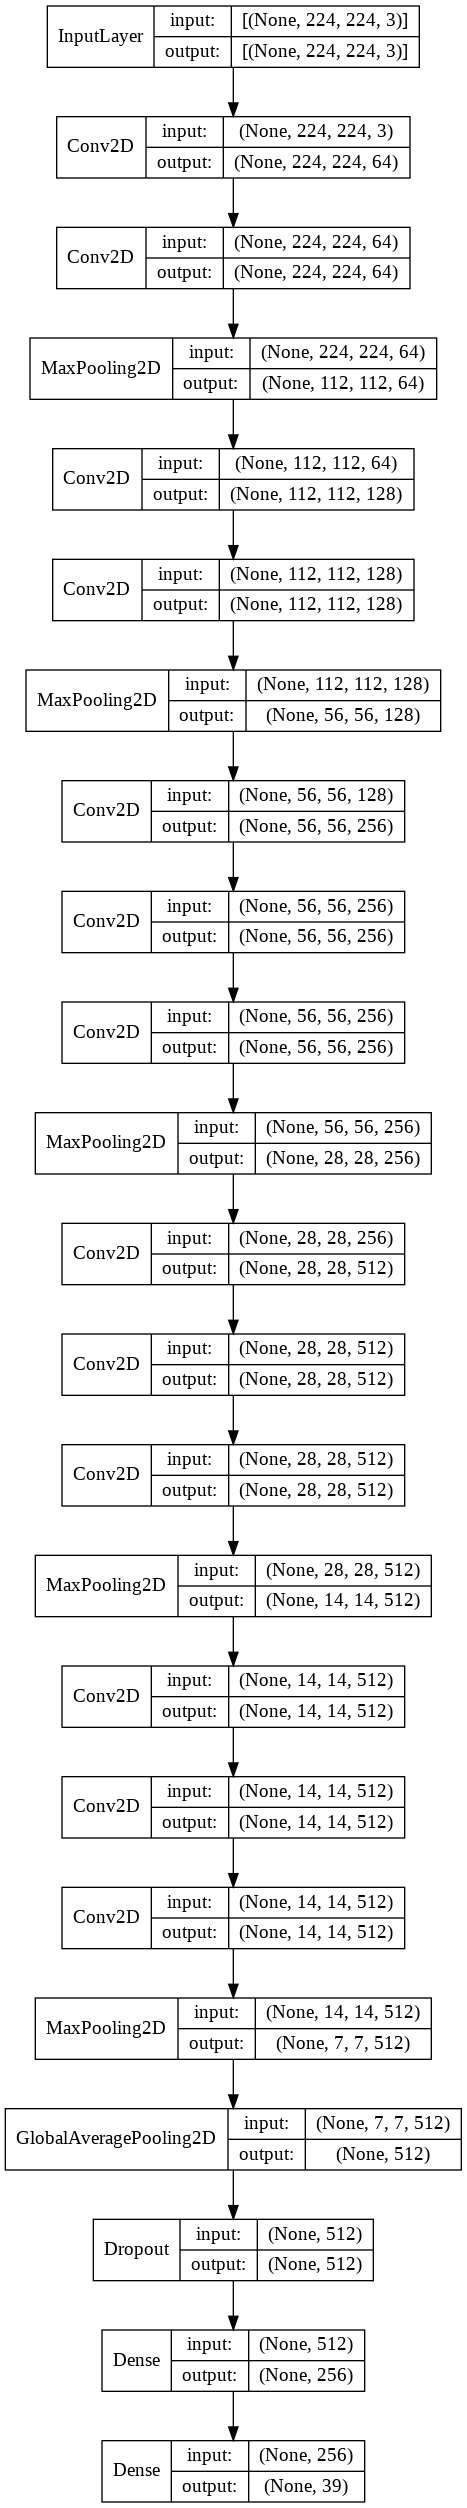

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)

## Compiling the Model

We need to compile the model with loss and metrics options. We have to make some different choices here.

Again, more details are to follow, but the final step we need to do before we can actually train our model with data is to [compile](https://keras.io/api/models/model_training_apis/#compile) it. Here we specify a [loss function](https://developers.google.com/machine-learning/glossary#loss) which will be used for the model to understand how well it is performing during training. We also specify that we would like to track `accuracy` while the model trains:

In [ ]:
model.compile(optimizer=optimizers.SGD(learning_rate=1e-3, momentum=0.9), 
              loss='categorical_crossentropy' ,
              metrics = ['accuracy']
              )

## Training the Model

Now that we have prepared training and validation data, and a model, it's time to train our model with our training data, and verify it with its validation data.

"Training a model with data" is often also called "fitting a model to data." Put this latter way, it highlights that the shape of the model changes over time to more accurately understand the data that it is being given.

When fitting (training) a model with Keras, we use the model's [fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method. It expects the following arguments:

* The training data
* The labels for the training data
* The number of times it should train on the entire training dataset (called an *epoch*)
* The validation or test data, and its labels

Run the cell below to train the model. We will discuss its output after the training completes:

In [ ]:
nbr_epochs = 10 
history=model.fit(train_generator,
          epochs=nbr_epochs,
          validation_data=validation_generator
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Saving the model & results

In [ ]:
target_dir = 
model.save(target_dir+'/my_model.h5')

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv(index=False)

# Analyzing results

In [ ]:
model = model = load_model(target_dir+'/my_model.h5')

## Observing Accuracy

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

NameError: ignored

## Confusion Matrix

In [ ]:
Classes_names =list(validation_generator.class_indices.keys())

In [ ]:
validation_generator.reset()
results = model.predict(validation_generator)
results = np.array(results)
predicted_labels_idx = np.argmax(results,axis=1)
predicted_labels_names = np.array([Classes_names[label] for label in predicted_labels_idx])
print(predicted_labels_names.shape)

(11004,)


In [ ]:
real_labels_idx = validation_generator.labels
real_labels_names = np.array([Classes_names[label] for label in real_labels_idx])
print(real_labels_names.shape)

(11004,)


In [ ]:
print(classification_report(real_labels_names,predicted_labels_names,labels=Classes_names))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.93      0.96       126
                                 Apple___Black_rot       0.98      0.97      0.98       125
                          Apple___Cedar_apple_rust       1.00      0.96      0.98        55
                                   Apple___healthy       0.99      0.97      0.98       329
                               Blueberry___healthy       0.98      1.00      0.99       300
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      0.99       210
                 Cherry_(including_sour)___healthy       0.98      0.99      0.99       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.89      0.83      0.86       103
                       Corn_(maize)___Common_rust_       0.99      0.99      0.99       239
               Corn_(maize)___Northern_Leaf_Blight       0.91      0.92      0.

In [ ]:
conf_matrix = confusion_matrix(real_labels_names,predicted_labels_names,labels=Classes_names,normalize='pred')
conf_matrix_df = pd.DataFrame(conf_matrix, index = Classes_names,columns = Classes_names)

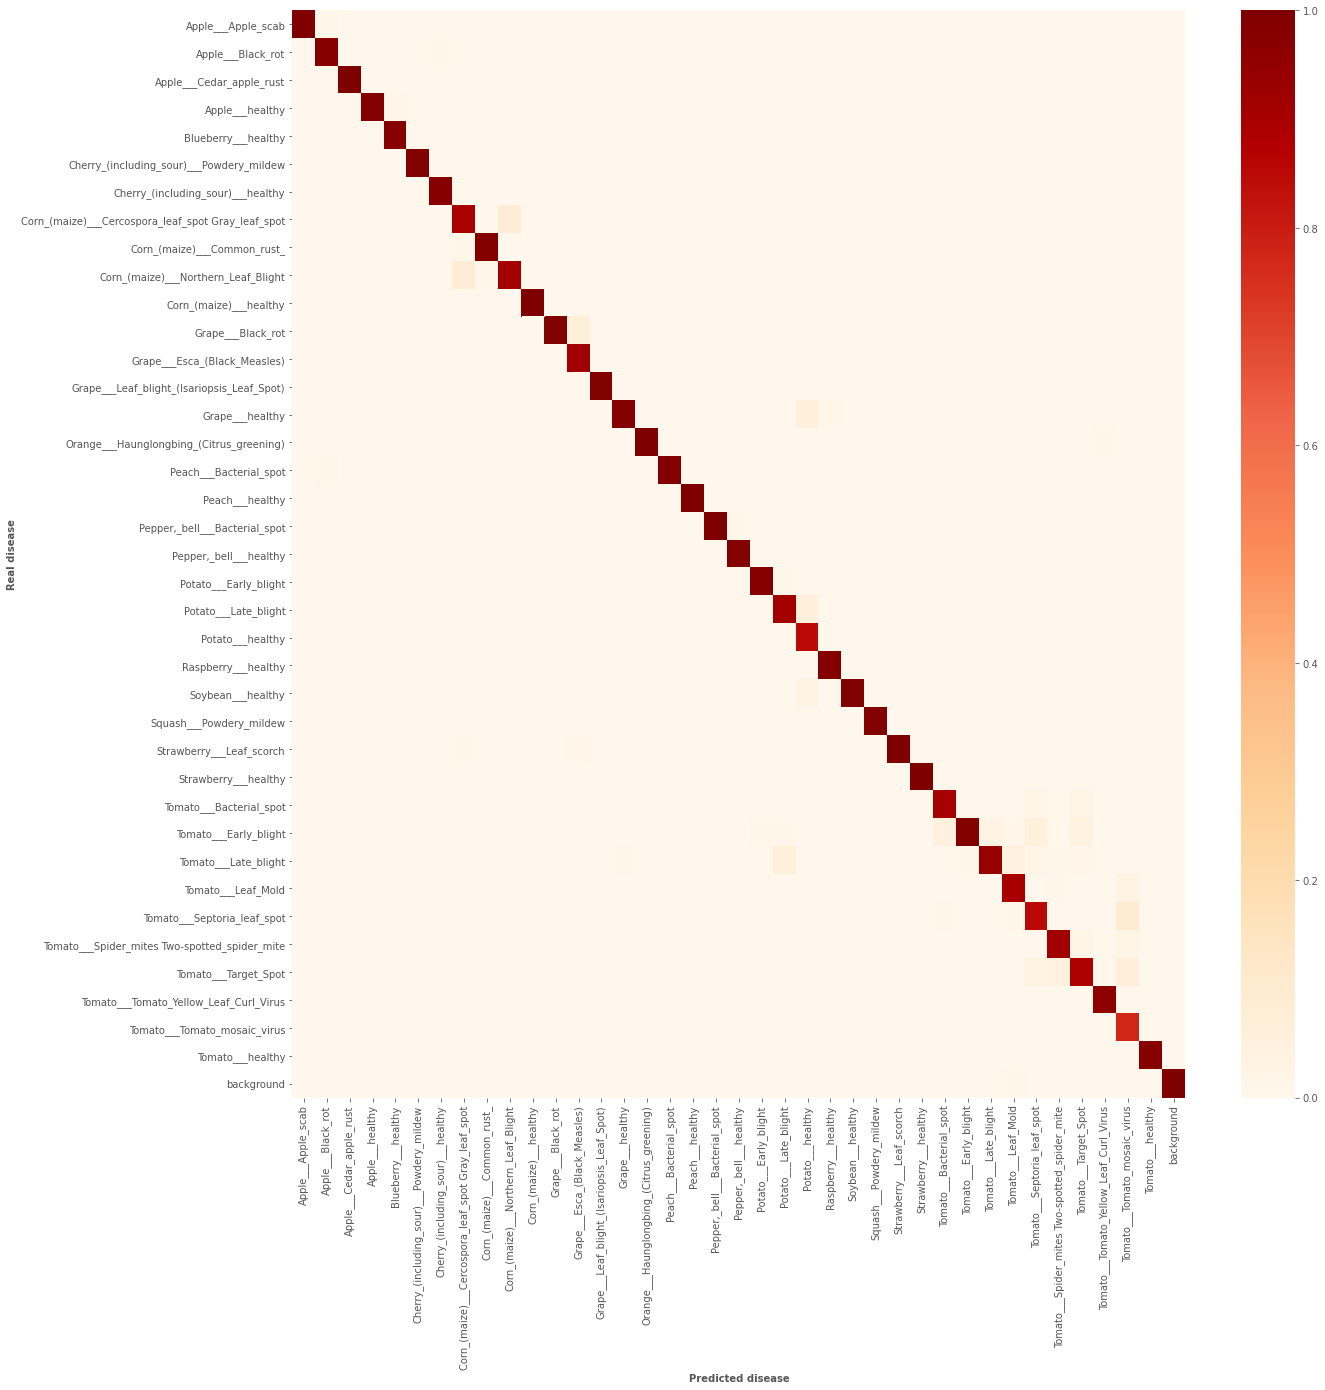

In [ ]:
plt.figure(figsize = (20,20))
heatmap = sn.heatmap(conf_matrix_df, annot=False,fmt='.2f',cmap="OrRd",vmin=0, vmax=1)
heatmap.set_xlabel('Predicted disease',fontsize = 10,fontweight="bold")
heatmap.set_ylabel('Real disease',fontsize = 10,fontweight="bold")
heatmap.figure.savefig("Confusion matrix.png")

## Examining the Predictions

In [ ]:
def prepare_image_for_prediction(img_path, size = (224,224)):
    # `img` is a PIL image of size 
    img = load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    array = array/255
    return array

def predict_class(image_path):
  image_array = prepare_image_for_prediction(image_path)
  result = model.predict(image_array)
  index_max = result.argmax(axis=1)[0]
  return Classes_names[index_max]

Correct : Orange___Haunglongbing_(Citrus_greening)


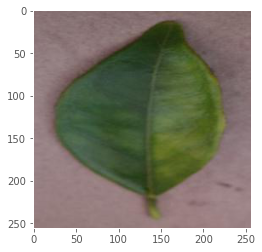

Correct : Tomato___Tomato_Yellow_Leaf_Curl_Virus


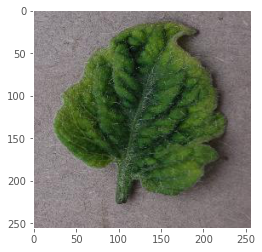

Correct : Tomato___Bacterial_spot


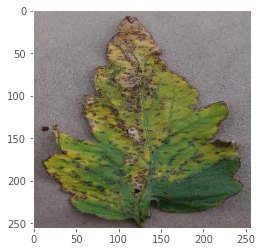

Correct : Tomato___Target_Spot


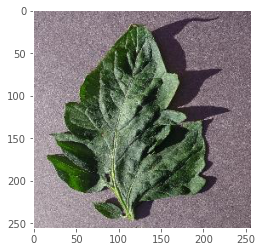

Correct : Tomato___Target_Spot


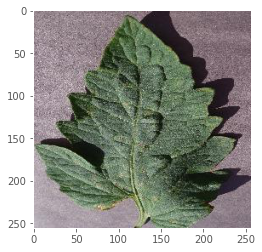

In [ ]:
plt.rcParams["axes.grid"] = False
number_images =5
selected_images_df = validation_df.sample(number_images)
for index, row in selected_images_df.iterrows():
  image_path = os.path.join(validation_path,row.Paths)
  real_class = row.Diseases
  predicted_class = predict_class(image_path)
  
  if(real_class == predicted_class):
    print("Correct : " + predict_class(image_path))
  else:
    print("Incorrect : " + real_class + " vs " + predict_class(image_path))

  plt.imshow(Image.open(image_path)) 
  plt.show()  # display it

  

## Examine incorrect classifications




Incorrect : Tomato___Target_Spot vs Corn_(maize)___Northern_Leaf_Blight


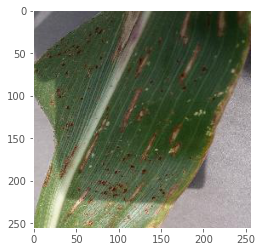

Incorrect : Tomato___Target_Spot vs Tomato___Tomato_Yellow_Leaf_Curl_Virus


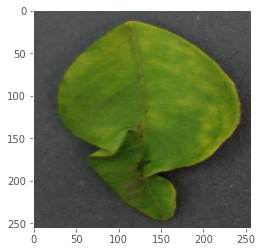

Incorrect : Tomato___Target_Spot vs Tomato___healthy


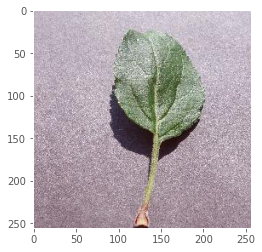

Incorrect : Tomato___Target_Spot vs Tomato___Septoria_leaf_spot


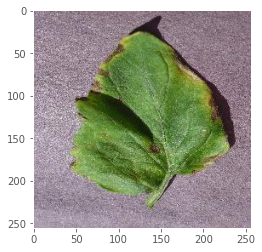

Incorrect : Tomato___Target_Spot vs Potato___Late_blight


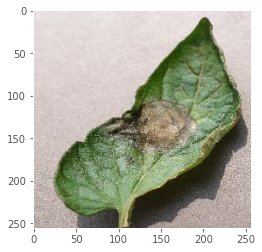

Incorrect : Tomato___Target_Spot vs Tomato___Tomato_Yellow_Leaf_Curl_Virus


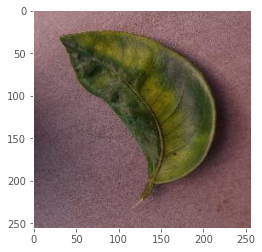

Incorrect : Tomato___Target_Spot vs Tomato___Spider_mites Two-spotted_spider_mite


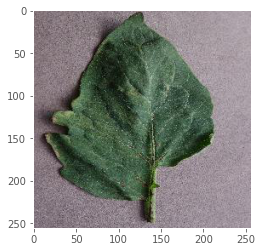

Incorrect : Tomato___Target_Spot vs Grape___Esca_(Black_Measles)


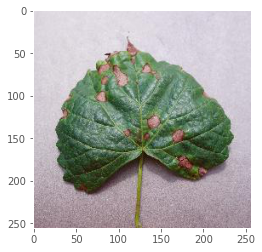

Incorrect : Tomato___Target_Spot vs Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


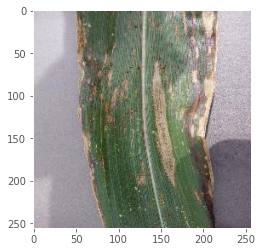

Incorrect : Tomato___Target_Spot vs Tomato___Septoria_leaf_spot


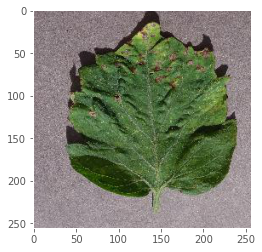

In [ ]:
nbr_errors = 10
errors_idxs = np.where(real_labels_names != predicted_labels_names)[0]
errors_paths = np.array(validation_generator.filepaths)[errors_idxs]
errors_sample_paths = random.choices(errors_paths, k=nbr_errors)
for image_path in errors_sample_paths:
  real_class = row.Diseases
  predicted_class = predict_class(image_path)
  print("Incorrect : " + real_class + " vs " + predict_class(image_path))
  plt.imshow(Image.open(image_path)) 
  plt.show()  # display it

## Grad-CAM class activation visualization 

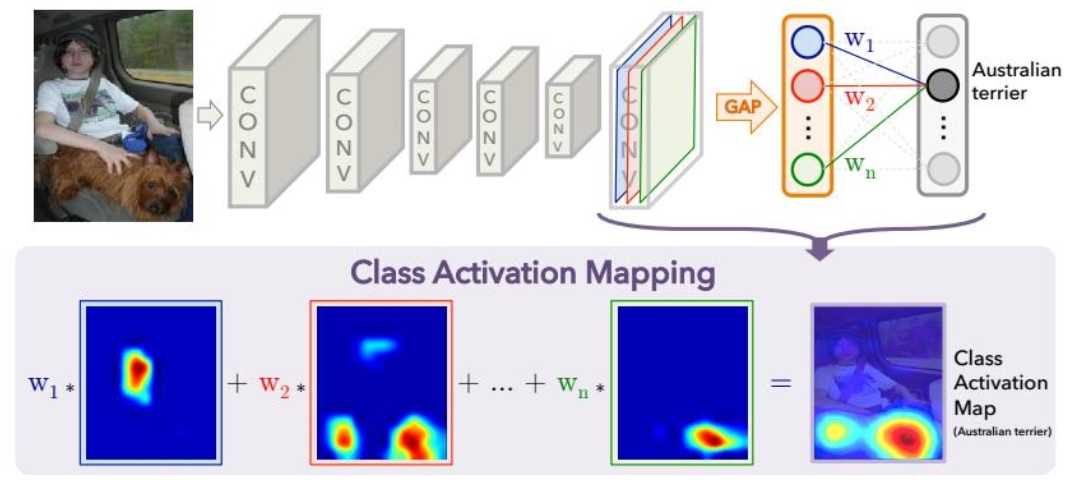

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Predicted: Tomato___Late_blight


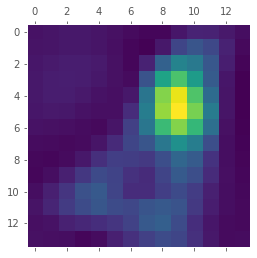

In [ ]:
img_path = '/content/PlantVillage/train/Tomato___Late_blight/0003faa8-4b27-4c65-bf42-6d9e352ca1a5___RS_Late.B 4946.JPG'

# Prepare image
img_array = prepare_image_for_prediction(img_path, size = (224,224))

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
print("Predicted:", predict_class(img_path))

# Generate class activation heatmap
last_conv_layer_name = 'block5_conv3'
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = load_img(img_path)
    img = img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)

    # Display Grad CAM
    plt.matshow(superimposed_img )
    plt.show()

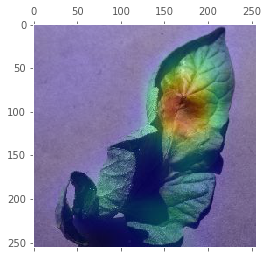

In [ ]:
display_gradcam(img_path, heatmap)

Incorrect : Tomato___Target_Spot vs Tomato___Bacterial_spot


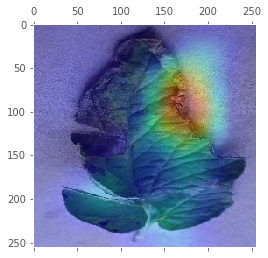

Incorrect : Tomato___Target_Spot vs Corn_(maize)___Northern_Leaf_Blight


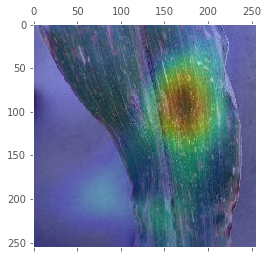

Incorrect : Tomato___Target_Spot vs Grape___Esca_(Black_Measles)


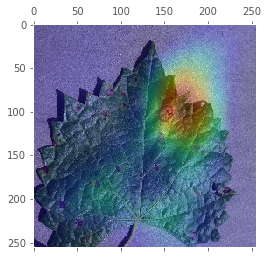

Incorrect : Tomato___Target_Spot vs Tomato___Tomato_Yellow_Leaf_Curl_Virus


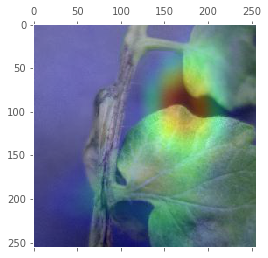

Incorrect : Tomato___Target_Spot vs Tomato___Spider_mites Two-spotted_spider_mite


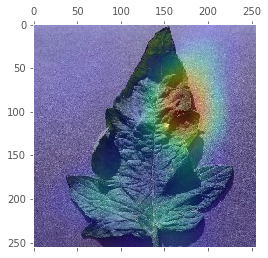

Incorrect : Tomato___Target_Spot vs Tomato___Target_Spot


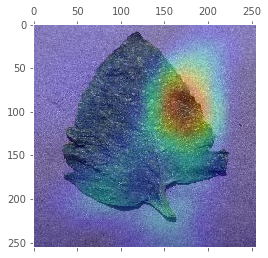

Incorrect : Tomato___Target_Spot vs Grape___Esca_(Black_Measles)


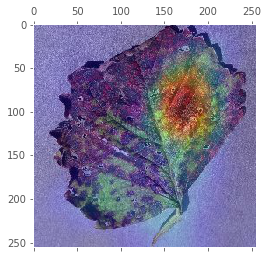

Incorrect : Tomato___Target_Spot vs Tomato___Leaf_Mold


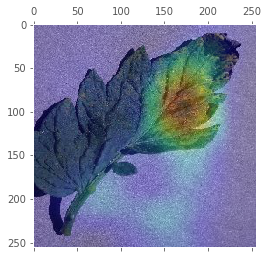

Incorrect : Tomato___Target_Spot vs Tomato___Tomato_mosaic_virus


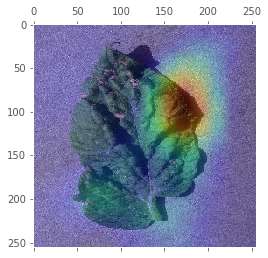

Incorrect : Tomato___Target_Spot vs Tomato___Spider_mites Two-spotted_spider_mite


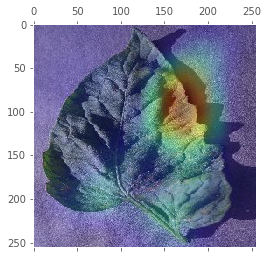

In [ ]:
nbr_errors = 10
errors_idxs = np.where(real_labels_names != predicted_labels_names)[0]
errors_paths = np.array(validation_generator.filepaths)[errors_idxs]
errors_sample_paths = random.choices(errors_paths, k=nbr_errors)
for image_path in errors_sample_paths:
  real_class = row.Diseases
  predicted_class = predict_class(image_path)
  print("Incorrect : " + real_class + " vs " + predict_class(image_path))
  display_gradcam(image_path, heatmap)
  plt.show()  # display it